In [60]:
import pandas as pd
df = pd.read_csv("cleaned_data_10000 (4).csv")

In [61]:
! pip install -U accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [62]:
! pip install -U transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [63]:
pip install --upgrade accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [64]:
df["Score"].value_counts()

 1    2854
-1    2795
 0    2717
Name: Score, dtype: int64

In [65]:
def replace_score(x):
  if x == 1:
    cat = "positive"
  elif x == 0 :
    cat = "neutre"
  elif x == -1:
    cat = "negative"
  return cat
df["category"] = df["Score"].apply(replace_score)
df["category"].value_counts()

positive    2854
negative    2795
neutre      2717
Name: category, dtype: int64

In [66]:
labels = df["category"].unique().tolist()
labels = [s.strip() for s in labels]
labels

['positive', 'negative', 'neutre']

In [67]:
num_labels = len(labels)
id2label = {id:label for id,label in enumerate(labels)}
label2id = {label:id for id,label in enumerate(labels)}

In [68]:
df["labels"] = df.category.map(lambda x: label2id[x.strip()])
df["labels"].value_counts()

0    2854
1    2795
2    2717
Name: labels, dtype: int64

<Axes: ylabel='category'>

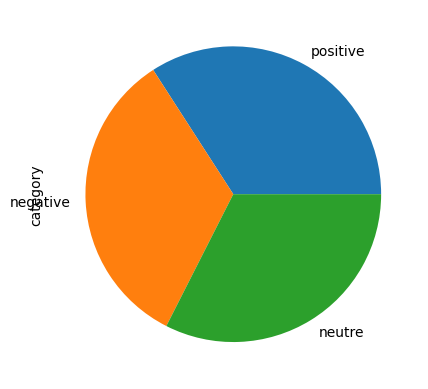

In [69]:
df.category.value_counts().plot(kind="pie")

In [70]:
from transformers import logging

logging.set_verbosity_warning()

In [71]:
from transformers import BertTokenizerFast , BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [72]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=num_labels,id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [73]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [74]:
df

,Unnamed: 0,Score,Text,category,labels
0,0,1,I buy vitality dog food product find good qual...,positive,0
1,2,1,confection century light pillowy citrus gelati...,positive,0
2,4,1,great taffy great price wide assortment yummy ...,positive,0
3,5,1,I wild hair taffy order pound bag taffy enjoya...,positive,0
4,6,1,saltwater taffy great flavor soft chewy candy ...,positive,0
...,...,...,...,...,...
8361,36907,0,dave gourmet probably hot food brand I hold hi...,neutre,2
8362,36928,0,I purchase item save calorie carb I primarily ...,neutre,2
8363,36934,0,I use nauseate tell I taste like sugar version...,neutre,2
8364,36985,0,I love starburst candy year favorite fave red ...,neutre,2


In [75]:
SIZE = df.shape[0]
train_texts = list(df.Text[:SIZE//2])
val_texts = list(df.Text[SIZE//2:(3*SIZE)//4])
test_texts = list(df.Text[(3*SIZE)//4:])

train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df.labels[(3*SIZE)//4:])


In [76]:
train_encodings = tokenizer(train_texts , truncation=True , padding=True)
val_encodings = tokenizer(val_texts , truncation=True , padding=True)
test_encodings = tokenizer(test_texts , truncation=True , padding=True)


In [77]:
from torch.utils.data import Dataset, DataLoader

class ReviewsDataLoader(Dataset):
  def __init__(self,encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [78]:
train_dataloader = ReviewsDataLoader(train_encodings, train_labels)
val_dataloader = ReviewsDataLoader(val_encodings, val_labels)
test_dataloader = ReviewsDataLoader(test_encodings, test_labels)

In [79]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall , f1 , _ = precision_recall_fscore_support(labels,preds,average="macro")
  acc = accuracy_score(labels,preds)

  return {
      "Accuarcy": acc,
      "F1":f1,
      "Precision":precision,
      "Recall":recall
  }

In [80]:
from transformers import TrainingArguments , Trainer

training_args = TrainingArguments(
    output_dir = ".TTModel",
    do_train = True,
    do_eval = True,

    num_train_epochs = 3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=36,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    # fp16=True,
    load_best_model_at_end=True
)

In [81]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataloader,
    eval_dataset = val_dataloader,
    compute_metrics=compute_metrics
)

In [82]:
trainer.train()

/Users/macmini/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuarcy,F1,Precision,Recall
50,0.885200,1.879696,0.047346,0.041825,0.294643,0.022510
100,0.465300,1.747470,0.608800,0.266457,0.246849,0.289450
150,0.404900,2.437396,0.352463,0.207664,0.272963,0.167576
200,0.418700,2.336801,0.522238,0.253041,0.257973,0.248295
250,0.370000,2.474045,0.485892,0.245945,0.262940,0.231014
300,0.276700,2.365490,0.552846,0.260097,0.257404,0.262847
350,0.219400,2.549182,0.562889,0.262080,0.256763,0.267622
400,0.219700,2.904799,0.474892,0.243561,0.264377,0.225784
450,0.207100,2.902727,0.458154,0.238933,0.264568,0.217826
500,0.282600,2.587505,0.557150,0.260714,0.256664,0.264893


/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/p

/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/p

TrainOutput(global_step=786, training_loss=0.2849970179356388, metrics={'train_runtime': 3930.9876, 'train_samples_per_second': 3.192, 'train_steps_per_second': 0.2, 'total_flos': 722270998546272.0, 'train_loss': 0.2849970179356388, 'epoch': 3.0})

In [83]:
q = [trainer.evaluate(eval_dataset=df) for df in [train_dataloader,val_dataloader,test_dataloader]]
pd.DataFrame(q,index=["train","eval","test"]).iloc[:,:5]

/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macmini/anaconda3/lib/p

,eval_loss,eval_Accuarcy,eval_F1,eval_Precision,eval_Recall
train,0.107597,0.966292,0.961242,0.959887,0.962633
eval,2.587505,0.557150,0.260714,0.256664,0.264893
test,7.252295,0.000000,0.000000,0.000000,0.000000


In [84]:
def predict(text):
  inputs = tokenizer(text, padding=True,truncation=True,max_length=512, return_tensors="pt").to("cuda")

  outputs = model(**inputs)

  probs = outputs[0].softmax(1)
  pred_label_idx = probs.argmax()


  pred_label = model.config.id2label[pred_label_idx.items()]
  return probs,pred_label_idx,pred_label

In [85]:
model_path = "amazon-text-classification-model-2024"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('amazon-text-classification-model-2024/tokenizer_config.json',
 'amazon-text-classification-model-2024/special_tokens_map.json',
 'amazon-text-classification-model-2024/vocab.txt',
 'amazon-text-classification-model-2024/added_tokens.json',
 'amazon-text-classification-model-2024/tokenizer.json')

In [86]:
from transformers import pipeline
model_path = "amazon-text-classification-model-2024"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model,tokenizer=tokenizer)

In [87]:
!pip install xformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [88]:
df.iloc[1500,:]["Text"]

'mix great taste waffle little extra work expense worth need stretch recipe little bit waffle new presto flipside belgian waffle maker'

In [89]:
ch = 'product arriv label jumbo salt peanut peanut actual small size unsalt sure thi wa error vendor intend repre product jumbo'

In [90]:
nlp(ch)

[{'label': 'negative', 'score': 0.9664924144744873}]

In [91]:
test = "cat food is good, iam gonna buy again"

In [94]:
nlp("this food tastes really bad, i'am not happy")

[{'label': 'negative', 'score': 0.9059119820594788}]